# Modeling a Pandemic

The so-called SIR model describes the spread of a disease in a population fixed to N individuals over time t. The model divides the population into three compartments: susceptible (S), infected (I), and recovered (R).  In this notebook, we will modify the SIR model by adding the possibility of mortality of infected (but not yet recovered) individuals.  This new model is governed by the following system of ordinary differential equations:

$$\begin{align}
\frac{dS}{dt} &= -\beta \frac{SI}{N} \\
\frac{dI}{dt} &= \beta \frac{SI}{N} - \gamma I \\
\frac{dR}{dt} &= \gamma I - \mu I \\
\frac{dM}{dt} &= \mu I
\end{align}$$


### The Modified SIR Model Parameters

The parameters of the model are as follows:

- $\beta$ is the average number of contacts per person per time, multiplied by the probability of disease transmission in a contact between a susceptible and an infectious subject.

- $\gamma$ is the average number of recovered individuals per time.

- $\mu$ is the average number of deaths per time.

Some remarks on the model :

The average infection period (i.e. the mean period during which an infected individual can pass it on) is equal to $\frac{1}{\gamma}$.

The assumption of a constant average number of contacts $\beta$ is a strong and constraining assumption : it cannot be applied to all diseases.

The model does not take into account many factors, including the following:

- the possibility of reinfection.

- the possibility of vaccination.

- the possibility of quarantine.

- the possibility of treatment.

- the possibility of mutation.

- the possibility of spatial heterogeneity.

- the possibility of age heterogeneity.

- the possibility of population heterogeneity.

- the possibility of seasonal variation.

- the possibility of migration.

We can imagine improving this model by taking into account for example:
newborns that would correspond to $S$ susceptible individuals. We would introduce a birth rate $b$.
the deceased who would leave the compartments $S$ or $I$ with the same rate $b$ : this allows to consider a constant population $N$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy import integrate

In [2]:
N = 350000000. #Total number of individuals, N
I0, R0, M0 = 1000., 0, 0 #Initial number of infected and recovered individuals
S0 = N - I0 - R0 - M0 #Susceptible individuals to infection initially is deduced
beta, gamma, mu = 0.4, 0.2, 0.03 #Contact rate and mean recovery rate and mortality rate (in 1/days)
tmax = 160 #A grid of time points (in days)
Nt = 160
t = np.linspace(0, tmax, Nt+1)

In [3]:
def SIRM_model(y, t, N, beta, gamma, mu):
    S, I, R, M = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I - mu * I
    dMdt = mu * I
    return np.array([dSdt, dIdt, dRdt, dMdt])

In [4]:
X0 = S0, I0, R0, M0 #Initial conditions vector
res = integrate.odeint(SIRM_model, X0, t, args=(N, beta, gamma, mu))
S, I, R, M = res.T
Seuil = 1 - 1 / (beta/gamma)
print("The epidemic will stop, and new infections will begin to decrease, when the number of infected people will be less than", Seuil*N, "individuals")

Rep0 = beta/gamma
print("The basic reproduction number is", Rep0)

The epidemic will stop, and new infections will begin to decrease, when the number of infected people will be less than 175000000.0 individuals
The basic reproduction number is 2.0


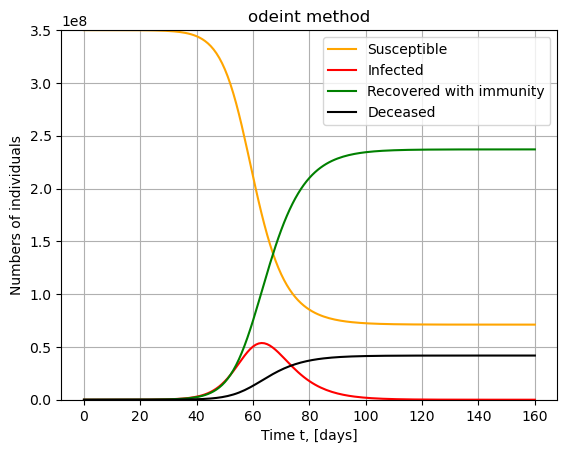

In [5]:
plt.figure()
plt.grid()
plt.title("odeint method")
plt.plot(t, S, 'orange', label='Susceptible')
plt.plot(t, I, 'r', label='Infected')
plt.plot(t, R, 'g', label='Recovered with immunity')
plt.plot(t, M, 'k', label='Deceased')
plt.xlabel('Time t, [days]')
plt.ylabel('Numbers of individuals')
plt.ylim([0,N])
plt.legend()

plt.show();

### Euler method

In [6]:
def Euler(func, X0, t, N, beta, gamma, mu):
    dt = t[1] - t[0]
    nt = len(t)
    X  = np.zeros([nt, len(X0)])
    X[0] = X0
    for i in range(nt-1):
        X[i+1] = X[i] + func(X[i], t[i], N, beta, gamma, mu) * dt
    return X

In [7]:
Xe = Euler(SIRM_model, X0, t, N, beta, gamma, mu)

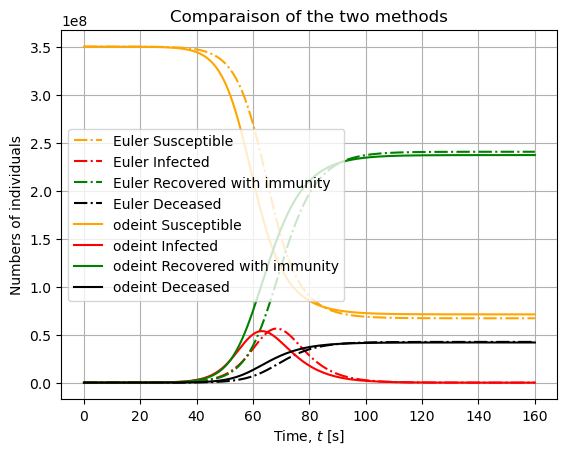

In [8]:
plt.figure()

plt.plot(t, Xe[:,0], color = 'orange', linestyle = '-.', label='Euler Susceptible')
plt.plot(t, Xe[:,1], 'r-.', label='Euler Infected')
plt.plot(t, Xe[:,2], 'g-.', label='Euler Recovered with immunity')
plt.plot(t, Xe[:,3], 'k-.', label='Euler Deceased')
plt.plot(t, S, 'orange', label='odeint Susceptible')
plt.plot(t, I, 'r', label='odeint Infected')
plt.plot(t, R, 'g', label='odeint Recovered with immunity')
plt.plot(t, M, 'k', label='odeint Deceased')
plt.grid()
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Numbers of individuals")
plt.legend(loc = "best")
plt.title("Comparaison of the two methods")
plt.show();

### What is $R_0$ ?

$R_0 = \frac{\beta}{\gamma}$ is a parameter describing the average number of new infections due to a sick individual. It’s commonly called the basic reproduction number. It’s a fundamental concept in epidemiology.

If $R_0$>1 the epidemic will persist. Otherwise, it will die out.

If a disease has an $R_0$=3 for example, on average, a person who has this sickness will pass it on to three other people.

## Investigating the effect of the contact rate $\beta$ on the epidemic

In [9]:
import ipywidgets as ipw

In [10]:
%matplotlib notebook


In [12]:
def update(beta = 0.2, gamma = 0.1, mu = 0.03):
    """
    Update function
    """
    I0, R0, M0 = 1000, 0, 0
    S0 = N - I0 - R0 - M0
    X0 = S0, I0, R0, M0

    sol = integrate.odeint(SIRM_model, X0, t, args = (N, beta, gamma, mu))
    line0.set_ydata(sol[:, 0])
    line1.set_ydata(sol[:, 1])
    line2.set_ydata(sol[:, 2])
    line3.set_ydata(sol[:, 3])

    txR0 = beta/gamma
    ax.set_title("$N$ = {0} $R_0$ = {1:.2f}".format(str(N).zfill(4), txR0))
    fig.canvas.draw()
    fig.canvas.flush_events()

Nt = 160
t = np.linspace(0., tmax, Nt)
X = np.zeros((Nt,4))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.grid()
line0, = ax.plot(t, X[:,0], "orange", label = "Susceptible")
line1, = ax.plot(t, X[:,1], "r", label = 'Infected')
line2, = ax.plot(t, X[:,2], "g", label = 'Recovered with immunity')
line3, = ax.plot(t, X[:,3], "k", label = 'Deceased')
ax.set_xlim(0., tmax)
ax.set_ylim(0., N)
ax.set_xlabel("Time, $t$ [day]")
ax.set_ylabel("Percentage of individuals")
plt.legend()

ipw.interact(update, beta = (0.,1., 0.01), gamma = (0.01, 1., 0.01), mu = (0.01, 0.10, 0.005))

<IPython.core.display.Javascript object>

interactive(children=(FloatSlider(value=0.2, description='beta', max=1.0, step=0.01), FloatSlider(value=0.1, d…

<function __main__.update(beta=0.2, gamma=0.1, mu=0.03)>